This is code for 
1. running our fmri scans through an autoencoder
2. encoding our fmri data from 4d scans to 1d arrays with a length of 1000
3. predicting schizophrenia with the encoded scans

right now the predictions are still no better than random chance. But this is a template for how to autoencoder could work. We still need to work on preprocessing the fmri data before it even gets to the autoencoder. The data is either too noisy or too big for the autoencoder to accuratly condense the information into something that can accuratly predict schizophrenia. One solution would also be to make the autoencoder way larger, but since the input layer has a vector length of over 3 million, even small increases make the autoencoder way larger quickly. This one has 6 billion total weight and bias parameters. Our best option at the moment would be to work on preprocessing before the autoencoder. 

In [2]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import nilearn

import keras
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from IPython.display import display

In [3]:
# To load these data files, look at other files in repository,
XData = np.load('/Users/KJP/Desktop/neural nets/Codes/XData.npy')
YData = np.load('/Users/KJP/Desktop/neural nets/Codes/YData.npy')

In [5]:
# fetch dataset
dataset = nilearn.datasets.fetch_cobre(n_subjects=146, data_dir="/Users/KJP/Desktop/neural nets/Cobre Dataset2", url=None, verbose=1)
file_paths = dataset["func"]
confounds = dataset["confounds"]
file_paths.sort() #sort file names by alphabetical order, which will result in sorting by patient number
confounds.sort()
del file_paths[74]                           # number 74 is misisng samples so it needs to be removed
del confounds[74]

In [7]:
# #fmri scans, l, h, w, time stamps for each scan
XData.shape

(145, 27, 32, 26, 150)

In [4]:
# standardize XData into X_scaled
X_scaled = XData.astype('float32').reshape(XData.shape[0],XData.shape[1]*XData.shape[2]*XData.shape[3]*XData.shape[4])
X_scaled  = X_scaled - X_scaled.mean()
X_scaled = X_scaled / X_scaled.max()


In [5]:
#Split X_scaled and YData into testing and training
x_train = X_scaled[:115]
x_test = X_scaled[115:]
y_train = YData[:115]
y_test = YData[115:]
display(x_train.shape)
display(x_test.shape)
display(y_train.shape)
display(y_test.shape)

(115, 3369600)

(30, 3369600)

(115, 2)

(30, 2)

In [8]:
#Make autoencoder network
input_dim = x_train.shape[1]
encoding_dim = 200

autoencoder = keras.Sequential()

# Encoder Layers
autoencoder.add(Dense(1000, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(500, activation='relu'))
autoencoder.add(Dense(200, activation='relu'))

autoencoder.add(Dense(encoding_dim, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(200, activation='relu'))
autoencoder.add(Dense(500, activation='relu'))
autoencoder.add(Dense(1000, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1000)              3369601000
_________________________________________________________________
dense_18 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_19 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_20 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_21 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_22 (Dense)             (None, 500)               100500    
_________________________________________________________________
dense_23 (Dense)             (None, 1000)              501000    
__________

In [12]:
# Make seperate encoder network from the autoencoder
input_img = Input(shape=(input_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder_layer4 = autoencoder.layers[3]

encoder = Model(input_img, encoder_layer4(encoder_layer3(encoder_layer2(encoder_layer1(input_img)))))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3369600)           0         
_________________________________________________________________
dense_17 (Dense)             (None, 1000)              3369601000
_________________________________________________________________
dense_18 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_19 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_20 (Dense)             (None, 200)               40200     
Total params: 3,370,241,900
Trainable params: 3,370,241,900
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=.0003, patience=10)

autoencoder.compile(optimizer=keras.optimizers.Adam(lr=.0005), loss='mean_squared_error')
history = autoencoder.fit(x_train[10:20, :], x_train[10:20, :],
                epochs=100,
                batch_size=10,
                validation_data=(x_test[:15,:], x_test[:15,:]),
                verbose = 1,
                callbacks=[early_stopping])
plt.figure()
# summarize history for accuracy
plt.subplot(211)
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()
score = autoencoder.evaluate(x_test, x_test, verbose=0)
print('Test loss:', score)

In [16]:
# encode all of our x data from a 4d fmri to 1000 length 1d array
X_encoded = encoder.predict(X_scaled)

In [25]:
# standardize X
X_encoded  = X_encoded - X_encoded.mean()
X_encoded = X_encoded / X_encoded.max()

In [26]:
x_train_encoded = X_encoded[:115, :]
x_test_encoded = X_encoded[115:, :]
display(x_train_encoded.shape)
display(x_test_encoded.shape)

(115, 1000)

(30, 1000)

In [ ]:
#train with X_encoded on a neural net

# Multi-layer net with ReLU hidden layer
model = keras.models.Sequential()
# Here we make the hidden layer (size 2) with a ReL
# activation function, but also initialize the bias
# weights in the network to a constant 0.1
model.add(keras.layers.Dense(10000,input_dim=len(X_encoded[0]),activation='relu',bias_initializer=keras.initializers.Constant(0.1)))
model.add(keras.layers.Dense(1000,activation='relu',bias_initializer=keras.initializers.Constant(0.1)))
model.add(keras.layers.Dense(100,activation='relu',bias_initializer=keras.initializers.Constant(0.1)))
# Output layer (size 1), sigmoid activation function
model.add(keras.layers.Dense(len(YData[0]),activation='softmax'))
# Compile as above (default learning rate and other
# hyperparameters for the Adam optimizer).
model.compile(loss='categorical_crossentropy',
             optimizer=keras.optimizers.Adam(lr=.0001),
             metrics=['accuracy'])
# Display the model
print(model.summary())

In [42]:
# Train it!
history = model.fit(x_train_encoded, y_train,
batch_size=100,
epochs=200,
verbose=1,
validation_split = 0.2)

Train on 92 samples, validate on 23 samples
Epoch 1/200
92/92 [==============================] - 2s 25ms/step - loss: 0.7119 - acc: 0.5435 - val_loss: 2.2129 - val_acc: 0.3913
Epoch 2/200
92/92 [==============================] - 1s 6ms/step - loss: 1.9944 - acc: 0.4565 - val_loss: 1.1672 - val_acc: 0.3913
Epoch 3/200
92/92 [==============================] - 1s 6ms/step - loss: 1.0650 - acc: 0.4565 - val_loss: 0.6790 - val_acc: 0.6087
Epoch 4/200
92/92 [==============================] - 0s 5ms/step - loss: 0.7211 - acc: 0.5435 - val_loss: 0.7080 - val_acc: 0.6087
Epoch 5/200
92/92 [==============================] - 0s 5ms/step - loss: 0.7733 - acc: 0.5435 - val_loss: 0.6858 - val_acc: 0.6087
Epoch 6/200
92/92 [==============================] - 0s 5ms/step - loss: 0.7372 - acc: 0.5435 - val_loss: 0.6703 - val_acc: 0.6087
Epoch 7/200
92/92 [==============================] - 0s 5ms/step - loss: 0.6973 - acc: 0.5435 - val_loss: 0.6908 - val_acc: 0.6087
Epoch 8/200
92/92 [===================

Epoch 63/200
92/92 [==============================] - 0s 4ms/step - loss: 0.6854 - acc: 0.5435 - val_loss: 0.6612 - val_acc: 0.6087
Epoch 64/200
92/92 [==============================] - 0s 4ms/step - loss: 0.6852 - acc: 0.5435 - val_loss: 0.6618 - val_acc: 0.6087
Epoch 65/200
92/92 [==============================] - 0s 5ms/step - loss: 0.6852 - acc: 0.5543 - val_loss: 0.6618 - val_acc: 0.6087
Epoch 66/200
92/92 [==============================] - 0s 4ms/step - loss: 0.6852 - acc: 0.5543 - val_loss: 0.6610 - val_acc: 0.6087
Epoch 67/200
92/92 [==============================] - 0s 4ms/step - loss: 0.6850 - acc: 0.5543 - val_loss: 0.6597 - val_acc: 0.6087
Epoch 68/200
92/92 [==============================] - 0s 4ms/step - loss: 0.6849 - acc: 0.5435 - val_loss: 0.6586 - val_acc: 0.6087
Epoch 69/200
92/92 [==============================] - 0s 4ms/step - loss: 0.6849 - acc: 0.5435 - val_loss: 0.6580 - val_acc: 0.6087
Epoch 70/200
92/92 [==============================] - 0s 4ms/step - loss: 0.

Epoch 125/200
92/92 [==============================] - 0s 4ms/step - loss: 0.6811 - acc: 0.5978 - val_loss: 0.6375 - val_acc: 0.6522
Epoch 126/200
92/92 [==============================] - 0s 5ms/step - loss: 0.6811 - acc: 0.5978 - val_loss: 0.6371 - val_acc: 0.6522
Epoch 127/200
92/92 [==============================] - 0s 5ms/step - loss: 0.6811 - acc: 0.5978 - val_loss: 0.6367 - val_acc: 0.6522
Epoch 128/200
92/92 [==============================] - 0s 5ms/step - loss: 0.6810 - acc: 0.5978 - val_loss: 0.6363 - val_acc: 0.6522
Epoch 129/200
92/92 [==============================] - 0s 4ms/step - loss: 0.6810 - acc: 0.5978 - val_loss: 0.6360 - val_acc: 0.6522
Epoch 130/200
92/92 [==============================] - 0s 4ms/step - loss: 0.6809 - acc: 0.5870 - val_loss: 0.6356 - val_acc: 0.6522
Epoch 131/200
92/92 [==============================] - 1s 6ms/step - loss: 0.6809 - acc: 0.5870 - val_loss: 0.6353 - val_acc: 0.6522
Epoch 132/200
92/92 [==============================] - 0s 5ms/step - 

Epoch 187/200
92/92 [==============================] - 1s 8ms/step - loss: 0.6798 - acc: 0.5543 - val_loss: 0.6204 - val_acc: 0.6087
Epoch 188/200
92/92 [==============================] - 1s 7ms/step - loss: 0.6798 - acc: 0.5543 - val_loss: 0.6204 - val_acc: 0.6087
Epoch 189/200
92/92 [==============================] - 1s 6ms/step - loss: 0.6798 - acc: 0.5543 - val_loss: 0.6202 - val_acc: 0.6087
Epoch 190/200
92/92 [==============================] - 1s 6ms/step - loss: 0.6798 - acc: 0.5543 - val_loss: 0.6201 - val_acc: 0.6087
Epoch 191/200
92/92 [==============================] - 1s 7ms/step - loss: 0.6798 - acc: 0.5543 - val_loss: 0.6200 - val_acc: 0.6087
Epoch 192/200
92/92 [==============================] - 1s 7ms/step - loss: 0.6798 - acc: 0.5543 - val_loss: 0.6199 - val_acc: 0.6087
Epoch 193/200
92/92 [==============================] - 1s 7ms/step - loss: 0.6798 - acc: 0.5543 - val_loss: 0.6198 - val_acc: 0.6087
Epoch 194/200
92/92 [==============================] - 1s 6ms/step - 

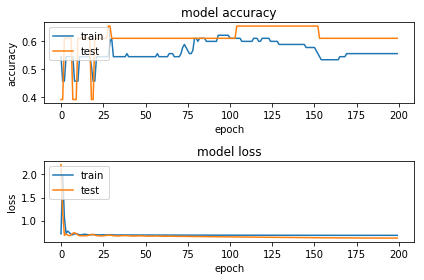

In [45]:
plt.figure()
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [46]:
score = model.evaluate(x_test_encoded, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.743468165397644
Test accuracy: 0.4333333373069763


In [ ]:
#Overall we still have not achieved better than random chance. The problem at the moment 
#is that we still need more preprocessing before the autoencoder
#Either the data is too noisy or too big for the autoencoder to accurately encode useful
#data for predicting schizophrenia